In [19]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt
import geopandas as gpd

import pymannkendall as mk

import math

from scipy.stats import friedmanchisquare


import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm

import statsmodels.formula.api as smf

import geopandas as gpd



# Read the data

In [202]:
df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed_for_regre.parquet')

df = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_otc_phc_imed.parquet')

df_pop = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Population/table_2009_2023_etcc_eq_zero.csv')

df_imed_key = pd.read_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv',sep = ';')

df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')


In [90]:
df_pop = df_pop[['Cód.', 'Uf', '2022']]

df_imed_key = df_imed_key[['Nome_UF', 'UF',  'Região Geográfica Imediata',
       'Nome Região Geográfica Imediata', 
       'Município', 'Código Município Completo', 'Nome_Município']]

df_pop = df_pop.rename(columns = {'Cód.': 'co_ibge7'}) 

df_imed_key = df_imed_key.rename(columns = {'Código Município Completo': 'co_ibge7', 
                                            'Região Geográfica Imediata': 'co_imed'})

df_imed_key = df_imed_key.merge(df_pop, on='co_ibge7', how='left')

df_imed_pop = df_imed_key.groupby(['co_imed'])['2022'].sum().reset_index()

df_imed_pop = df_imed_pop.assign(pop_2022 = df_imed_pop['2022'].astype(int))
df_imed_pop = df_imed_pop[['co_imed', 'pop_2022']]


df_codes_imed = df_imed_key.groupby(['Nome_UF','UF', 'co_imed','Uf'])['2022'].sum().reset_index()


# Analise trend and seasonalite by immediate region

In [65]:
dta_aih = df_aih[['co_imed', 'year_week',  'n',
       'aih_4',  'p_values_negbi_aih_4', 'trend_line_negbi_aih_4',
                  'dtrend_aih_negbi',
        'p_value_aih_negbi_friedman','warning_final_aih']]

In [66]:
dta = df[['sigla_uf', 'co_uf', 'nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas',
       'num_otc_ivas', 'atend_ivas_4', 'num_otc_ivas_4', 'dtrend_ivas_negbi',
       'dtrend_otc_negbi', 'trend_line_negbi_atend_ivas_4',
       'trend_line_negbi_num_otc_ivas_4', 'p_values_negbi_atend_ivas_4',
       'p_values_negbi_num_otc_ivas_4', 'p_value_ivas_negbi_friedman',
       'p_value_otc_negbi_friedman', 'seas_decom_aps', 'seas_decom_otc']]

In [67]:
dta2 = dta.merge(dta_aih, on = ['co_imed', 'year_week'], how = 'left')

In [68]:
dta_sea = dta2[dta2.p_value_aih_negbi_friedman <= 0.05]

In [69]:
lst_dfs_cities = []

for code in dta_sea.co_imed.unique():
    
    set_muni = dta_sea[dta_sea.co_imed == code]

    lst_dfs_cities.append(set_muni)

lst_dfs_cities = early_warning_detection_functions.harmonic(lst_dfs_cities, 'aih_4')

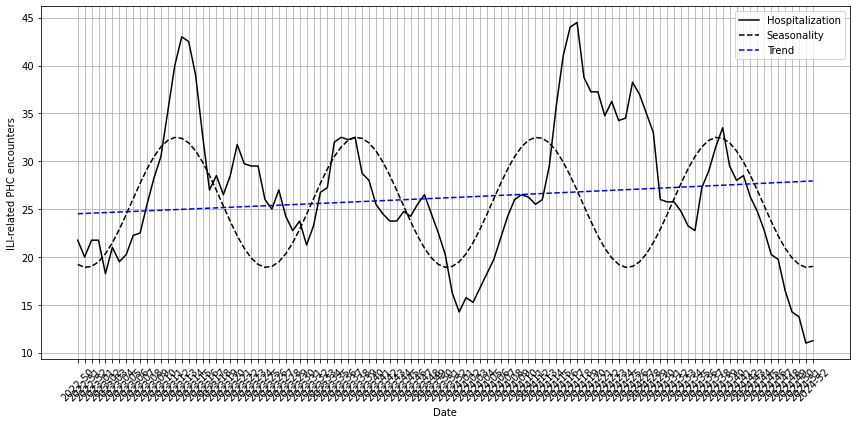

In [70]:
# 4
s = 4
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)
dta_plot = pd.concat(lst_dfs_cities)

set_imed = dta_plot[dta_plot.co_imed == 520007]



trend = set_imed.aih_4 - set_imed.dtrend_aih_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(set_imed['year_week'][3:], set_imed['aih_4'][3:], label='Hospitalization', color='black')

# Plot seasonality
plt.plot(set_imed['year_week'][3:], set_imed['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(set_imed['year_week'][3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
#plt.title(lst_dfs_cities[4].Nome_imed.iloc[0] + ' - ' + lst_dfs_cities[4].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('ILI-related PHC encounters')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [71]:
# Reagions with significant seasonality in AIH data
aih_sea = pd.concat(lst_dfs_cities)

In [72]:
lst = []

for value in aih_sea.co_imed.unique():
    
    data =  aih_sea[aih_sea.co_imed == value]
    
    data = data[data.Reconstructed == data.Reconstructed.max()]
    
    data = data[['sigla_uf','co_uf','nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end','n','warning_final_aih']]
    
    lst.append(data)

In [73]:
dta_pick_week_aih = pd.concat(lst)

In [74]:
dta_pick_week_aih = dta_pick_week_aih.assign(year = dta_pick_week_aih.year_week.astype(str).str[0:4].astype(int),
                                            week = dta_pick_week_aih.year_week.astype(str).str[5:].astype(int),
                                            ones = 1)

In [32]:
#dta_pick_week_aih.groupby(['year','week'])['ones'].sum().reset_index()

In [75]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)



In [76]:
dta_pick_week_aih = dta_pick_week_aih.assign(co_imed = dta_pick_week_aih['co_imed'].astype(str))

In [77]:
dta_pick_week_aih_2023 = dta_pick_week_aih[dta_pick_week_aih.year == 2023]

In [78]:
#dta_pick_week_aih_2023.co_imed.nunique()
#dta_pick_week_aih_2023[dta_pick_week_aih_2023.co_imed.duplicated().astype(int) == 1]
#dta_pick_week_aih_2023[dta_pick_week_aih_2023.co_imed == '520007']

dta_pick_week_aih_2023 = dta_pick_week_aih_2023.drop([10823])

In [79]:
gdf1 = gdf.merge(dta_pick_week_aih_2023, on = 'co_imed', how = 'left')

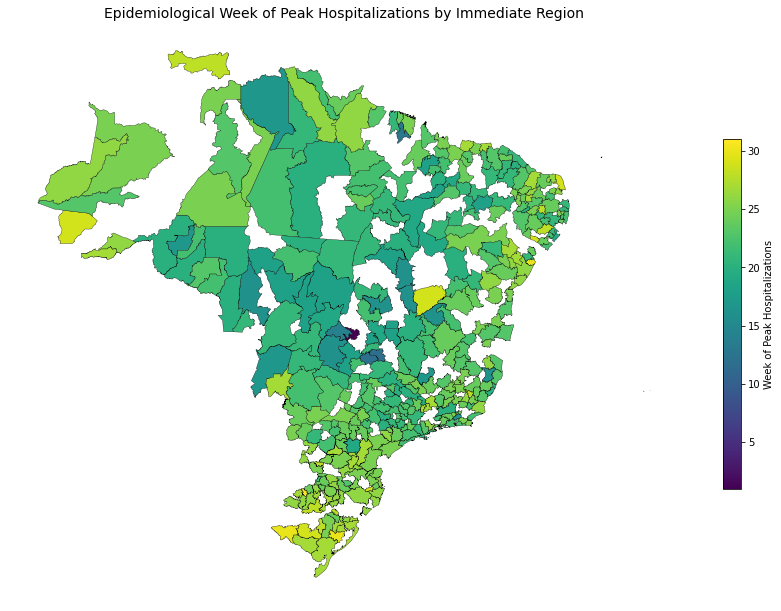

In [80]:
# Clean data
#gdf1 = gdf.dropna(subset=['year_week'])  # remove rows without peak info

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf1.plot(column='week', ax=ax, cmap='viridis', legend=True,
         legend_kwds={'label': "Week of Peak Hospitalizations", 'shrink': 0.5},
         edgecolor='black', linewidth=0.3,
         )


ax.set_title("Epidemiological Week of Peak Hospitalizations by Immediate Region", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()


In [81]:
#gdf1.sort_values(by=['week'])

gdf1.week.max()

31.0

In [87]:
# Plot hospitalizations by 100.000 inhabitants to see starting of cases
dta_aih2 = df_aih[['co_imed', 'year_week','n','warning_final_aih']]

In [97]:
dta_aih2 = dta_aih2.merge(df_codes_imed , on = 'co_imed', how = 'left')

In [99]:
dta_aih2 = dta_aih2.assign(n_inc = dta_aih2.n*100000/dta_aih2['2022'])

In [101]:
dta_aih2 = dta_aih2.assign(year = dta_aih2.year_week.astype(str).str[0:4].astype(int),
                                            week = dta_aih2.year_week.astype(str).str[5:].astype(int)
                                            )

In [114]:
dta_aih3 = dta_aih2[dta_aih2.year == 2023][['co_imed',  'warning_final_aih', 'n_inc', 'year', 'week']]

In [115]:
dta_aih3 = dta_aih3.assign(co_imed = dta_aih3.co_imed.astype(str))

In [148]:
lst = []
for code in dta_aih3.co_imed.unique():
    set_imed = dta_aih3[dta_aih3.co_imed == code]
    
    set_imed = set_imed.assign(n_inc_cum = set_imed.n_inc.cumsum())
    
    lst.append(set_imed)

In [149]:
dta_aih3 = pd.concat(lst)

In [179]:

def plot_incidence_warning_map(gdf_geom, df_data, week, cmap='Blues'):
    """
    Plots a choropleth map of cumulative incidence with warning markers for a given week.
    
    Parameters:
    - gdf_geom: GeoDataFrame with geometry and 'co_imed'
    - df_data: DataFrame with 'co_imed', 'week', 'n_inc_cum', 'warning_final_aih'
    - week: int, epidemiological week to plot
    - cmap: str, colormap name for incidence
    """
    # Merge geometry with incidence/warning data
    gdf_week = gdf_geom.merge(df_data[df_data.week == week], on='co_imed', how='left')
    
    # Plot base map
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf_week.plot(
        column='n_inc_cum',
        cmap=cmap,
        ax=ax,
        legend=True,
        legend_kwds={'label': f"Cumulative Incidence – Week {week}", 'shrink': 0.5},
        edgecolor='black',
        linewidth=0.3,
        missing_kwds={'color': 'lightgray'}
    )

    # Overlay warning markers if they exist
    gdf_warnings = gdf_week[gdf_week['warning_final_aih'] == 1]
    if not gdf_warnings.empty:
        gdf_warnings.geometry.centroid.plot(
            ax=ax,
            color='red',
            marker='*',
            markersize=50,
            label='Warning'
        )
        ax.legend(loc='lower left')

    # Final touches
    ax.set_title(f"Cumulative Incidence and Warnings – Week {week}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


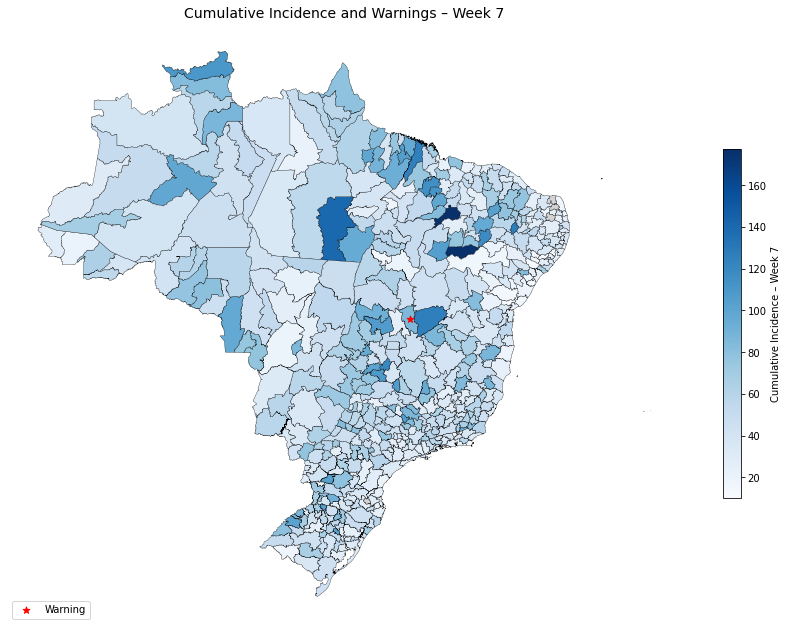

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


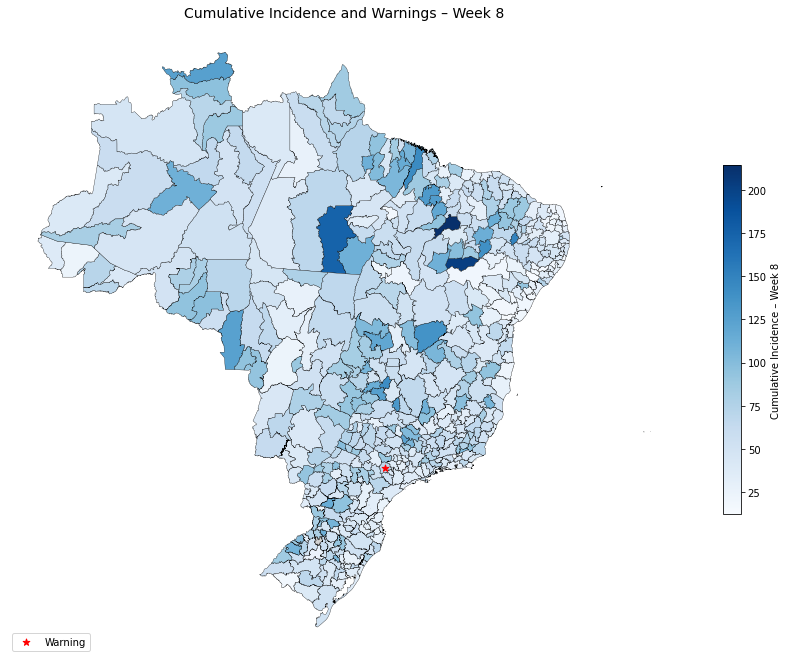

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


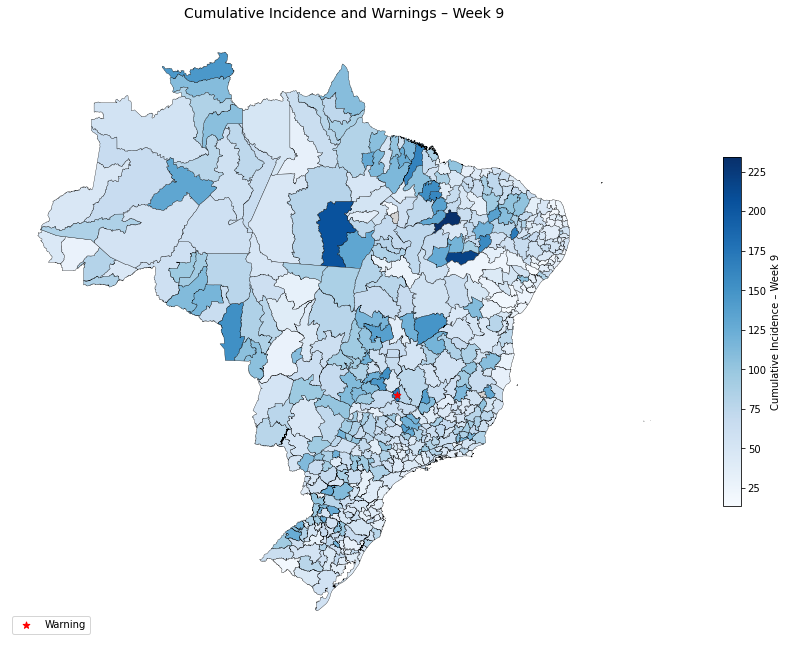

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


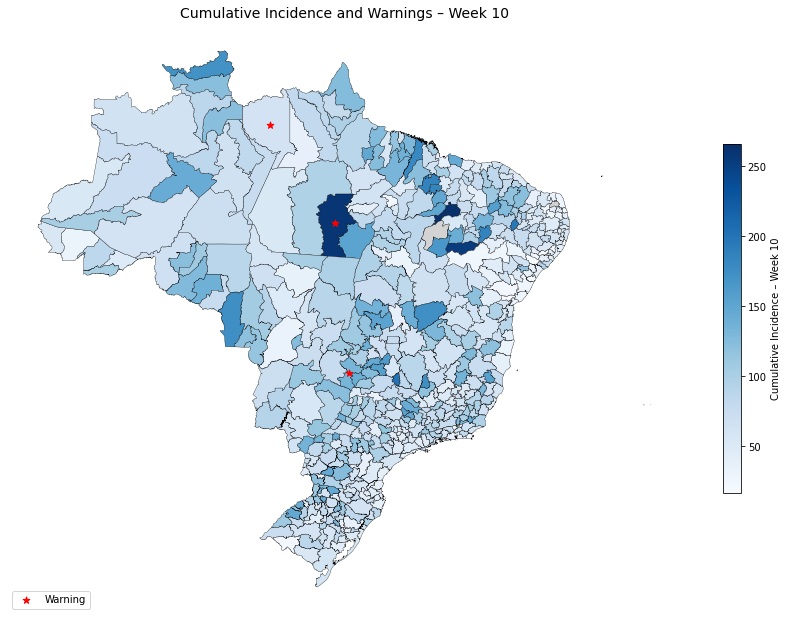

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


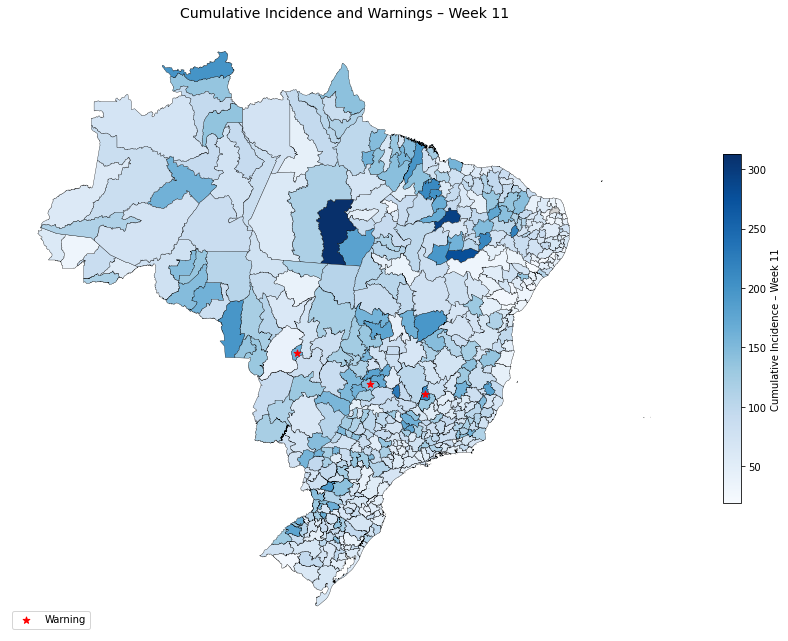

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


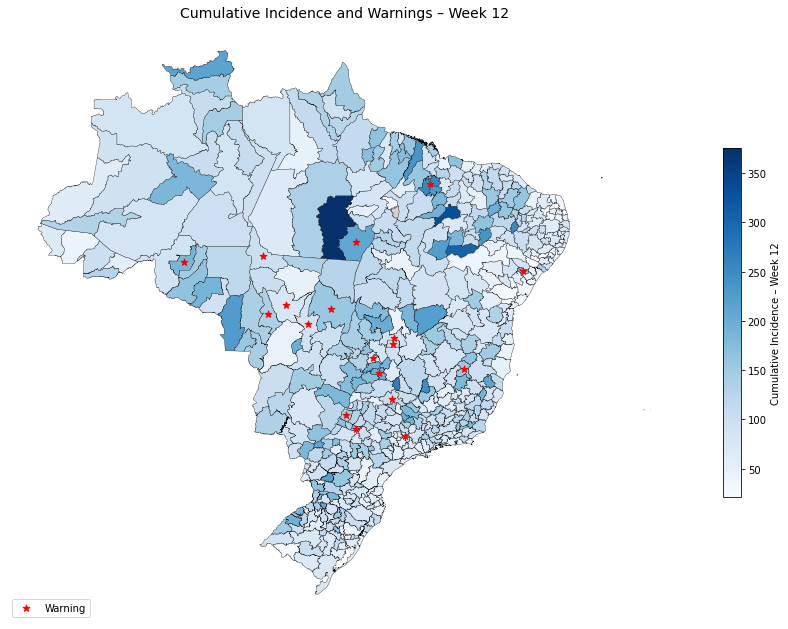

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


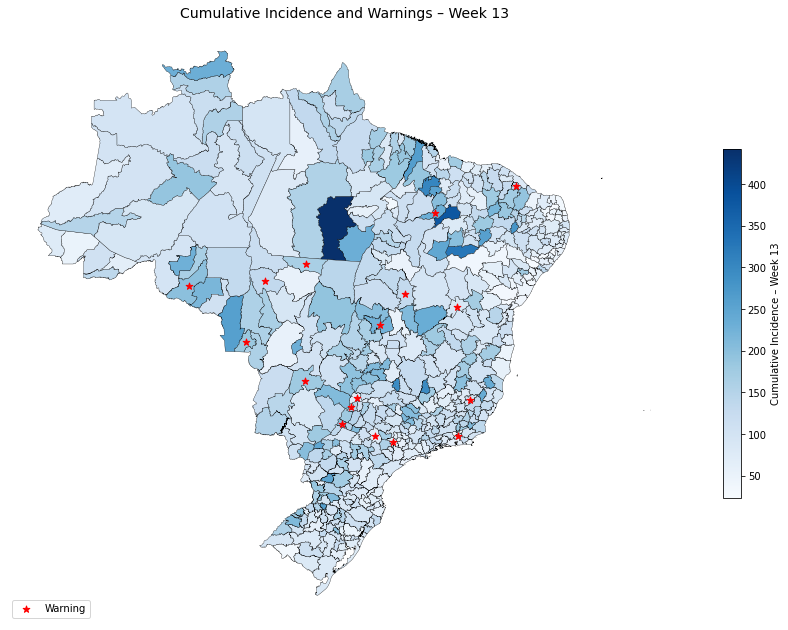

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


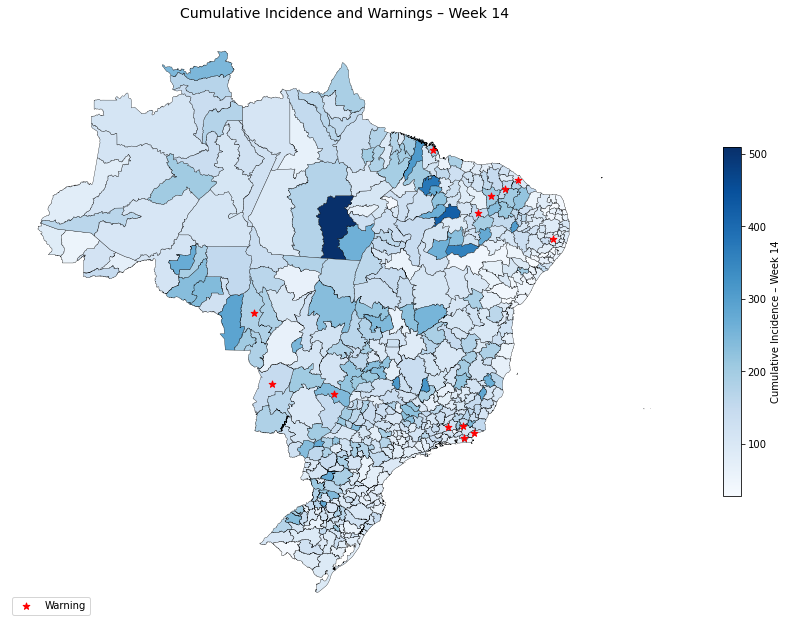

In [185]:
for wk in range(7, 15):
    plot_incidence_warning_map(gdf, dta_aih3, week=wk)


# Analyse APS

In [206]:
dta2 = dta.merge(dta_aih, on = ['co_imed', 'year_week'], how = 'left')

In [192]:
dta_sea = dta2[dta2.p_value_ivas_negbi_friedman <= 0.05]

In [193]:
lst_dfs_cities = []

for code in dta_sea.co_imed.unique():
    
    set_muni = dta_sea[dta_sea.co_imed == code]

    lst_dfs_cities.append(set_muni)

lst_dfs_cities = early_warning_detection_functions.harmonic(lst_dfs_cities, 'atend_ivas_4')

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [195]:
dta_plot

sigla_uf  co_uf      nm_uf  co_imed   Nome_imed year_week year_week_ts  \
0           AC     12       Acre   120001  Rio Branco   2022-47   2022-11-21   
1           AC     12       Acre   120001  Rio Branco   2022-48   2022-11-28   
2           AC     12       Acre   120001  Rio Branco   2022-49   2022-12-05   
3           AC     12       Acre   120001  Rio Branco   2022-50   2022-12-12   
4           AC     12       Acre   120001  Rio Branco   2022-51   2022-12-19   
...        ...    ...        ...      ...         ...       ...          ...   
56095       TO     17  Tocantins   170011  Dianópolis   2024-48   2024-11-25   
56096       TO     17  Tocantins   170011  Dianópolis   2024-49   2024-12-02   
56097       TO     17  Tocantins   170011  Dianópolis   2024-50   2024-12-09   
56098       TO     17  Tocantins   170011  Dianópolis   2024-51   2024-12-16   
56099       TO     17  Tocantins   170011  Dianópolis   2024-52   2024-12-23   

      epidemi_cal_start epidemi_cal_end  atend_ivas  ...  cos_3  sin_3  cos_5  \
0            2022-11-20      2022-11-26        1042  ...    NaN    NaN    NaN   
1            2022-11-27      2022-12-03        1018  ...    NaN    NaN    NaN   
2            2022-12-04      2022-12-10        1241  ...    NaN    NaN    NaN   
3            2022-12-11      2022-12-17        1498  ...    NaN    NaN    NaN   
4            2022-12-18      2022-12-24        1028  ...    NaN    NaN    NaN   
...                 ...             ...         ...  ...    ...    ...    ...   
56095        2024-11-24      2024-11-30         340  ...    NaN    NaN    NaN   
56096        2024-12-01      2024-12-07         314  ...    NaN    NaN    NaN   
56097        2024-12-08      2024-12-14         273  ...    NaN    NaN    NaN   
56098        2024-12-15      2024-12-21         290  ...    NaN    NaN    NaN   
56099        2024-12-22      2024-12-28          66  ...    NaN    NaN    NaN   

       sin_5  cos_4  sin_4  cos_6  sin_6  cos_7  sin_7  
0        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
1        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
3        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
4        NaN    NaN    NaN    NaN    NaN    NaN    NaN  
...      ...    ...    ...    ...    ...    ...    ...  
56095    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
56096    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
56097    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
56098    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
56099    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[43890 rows x 48 columns]

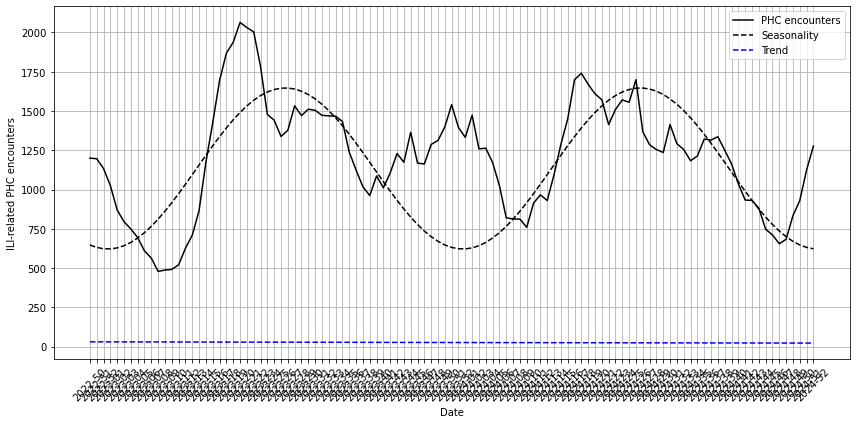

In [198]:
# 4
s = 4
# Ensure 'year_week' is in datetime format (convert 'year_week' to datetime)
dta_plot = pd.concat(lst_dfs_cities)

set_imed = dta_plot[dta_plot.co_imed == 120001]



trend = set_imed.aih_4 - set_imed.dtrend_aih_negbi  

# Plotting the components
plt.figure(figsize=(12, 6))

# Plot original series
plt.plot(set_imed['year_week'][3:], set_imed['atend_ivas_4'][3:], label='PHC encounters', color='black')

# Plot seasonality
plt.plot(set_imed['year_week'][3:], set_imed['Reconstructed'][3:], label='Seasonality', color='black', linestyle='dashed')

# Plot trend
plt.plot(set_imed['year_week'][3:], trend[3:], label='Trend', color='blue', linestyle='dashed')

# Formatting the plot
#plt.title(lst_dfs_cities[4].Nome_imed.iloc[0] + ' - ' + lst_dfs_cities[4].nm_uf.iloc[0])
plt.xlabel('Date')
plt.ylabel('ILI-related PHC encounters')
plt.xticks(rotation=45)  # Rotate date labels for better visibility

# Set grid for better readability
plt.grid(True)

# Add legend to the plot
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [199]:
# Reagions with significant seasonality in AIH data
phc_sea = pd.concat(lst_dfs_cities)

In [209]:
phc_sea.merge(df_aps, on = ['co_imed', 'year_week'], how = 'left')

sigla_uf  co_uf    nm_uf_x  co_imed Nome_imed_x year_week  \
0           AC     12       Acre   120001  Rio Branco   2022-47   
1           AC     12       Acre   120001  Rio Branco   2022-48   
2           AC     12       Acre   120001  Rio Branco   2022-49   
3           AC     12       Acre   120001  Rio Branco   2022-50   
4           AC     12       Acre   120001  Rio Branco   2022-51   
...        ...    ...        ...      ...         ...       ...   
43885       TO     17  Tocantins   170011  Dianópolis   2024-48   
43886       TO     17  Tocantins   170011  Dianópolis   2024-49   
43887       TO     17  Tocantins   170011  Dianópolis   2024-50   
43888       TO     17  Tocantins   170011  Dianópolis   2024-51   
43889       TO     17  Tocantins   170011  Dianópolis   2024-52   

      year_week_ts_x epidemi_cal_start_x epidemi_cal_end_x  atend_ivas_x  ...  \
0         2022-11-21          2022-11-20        2022-11-26          1042  ...   
1         2022-11-28          2022-11-27        2022-12-03          1018  ...   
2         2022-12-05          2022-12-04        2022-12-10          1241  ...   
3         2022-12-12          2022-12-11        2022-12-17          1498  ...   
4         2022-12-19          2022-12-18        2022-12-24          1028  ...   
...              ...                 ...               ...           ...  ...   
43885     2024-11-25          2024-11-24        2024-11-30           340  ...   
43886     2024-12-02          2024-12-01        2024-12-07           314  ...   
43887     2024-12-09          2024-12-08        2024-12-14           273  ...   
43888     2024-12-16          2024-12-15        2024-12-21           290  ...   
43889     2024-12-23          2024-12-22        2024-12-28            66  ...   

       atend_ivas_4_y  num_otc_ivas_4_y  \
0                0.00              0.00   
1                0.00              0.00   
2                0.00              0.00   
3             1199.75          17484.50   
4             1196.25          15192.50   
...               ...               ...   
43885          227.50           1271.00   
43886          261.00           1628.25   
43887          284.00           1774.00   
43888          304.25           1648.25   
43889          235.75           1457.00   

                                     best_formula    best_aic  \
0      atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1767.30052   
1      atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1767.30052   
2      atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1767.30052   
3      atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1767.30052   
4      atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1767.30052   
...                                           ...         ...   
43885  atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1496.06617   
43886  atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1496.06617   
43887  atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1496.06617   
43888  atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1496.06617   
43889  atend_ivas_4 ~ Reconstructed + phc_4_lag_1  1496.06617   

       fitted_values_phc_only  residuals_phc_only  UCL_phc_only  LCL_phc_only  \
0                  375.062837           -8.544965           NaN           NaN   
1                  375.301754           -8.545691           NaN           NaN   
2                  375.498734           -8.546289           NaN           NaN   
3                  375.650837            4.500951           NaN           NaN   
4                 1151.869278            0.119797   1499.126563    804.611994   
...                       ...                 ...           ...           ...   
43885              218.961577            0.119090    243.299161    194.623992   
43886              231.097473            0.384833    246.760917    215.434030   
43887              252.534448            0.371731    264.862520    240.206377   
43888              268.661197            0.394719    288.025619    249.296775   
43889              283.893247          

In [210]:
df_aps['co_imed',]

Index(['nm_uf', 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts',
       'epidemi_cal_start', 'epidemi_cal_end', 'atend_ivas', 'num_otc_ivas',
       'atend_ivas_4', 'num_otc_ivas_4', 'best_formula', 'best_aic',
       'fitted_values_phc_only', 'residuals_phc_only', 'UCL_phc_only',
       'LCL_phc_only', 'out_of_limits_above_phc_only',
       'out_of_limits_below_phc_only'],
      dtype='object')

In [72]:
lst = []

for value in phc_sea.co_imed.unique():
    
    data =  phc_sea[phc_sea.co_imed == value]
    
    data = data[data.Reconstructed == data.Reconstructed.max()]
    
    data = data[['sigla_uf','co_uf','nm_uf', 'co_imed', 'Nome_imed', 'year_week',
       'year_week_ts', 'epidemi_cal_start', 'epidemi_cal_end',]]
    
    lst.append(data)

In [73]:
dta_pick_week_aih = pd.concat(lst)

In [74]:
dta_pick_week_aih = dta_pick_week_aih.assign(year = dta_pick_week_aih.year_week.astype(str).str[0:4].astype(int),
                                            week = dta_pick_week_aih.year_week.astype(str).str[5:].astype(int),
                                            ones = 1)

In [32]:
#dta_pick_week_aih.groupby(['year','week'])['ones'].sum().reset_index()

In [75]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)



In [76]:
dta_pick_week_aih = dta_pick_week_aih.assign(co_imed = dta_pick_week_aih['co_imed'].astype(str))

In [77]:
dta_pick_week_aih_2023 = dta_pick_week_aih[dta_pick_week_aih.year == 2023]

In [78]:
#dta_pick_week_aih_2023.co_imed.nunique()
#dta_pick_week_aih_2023[dta_pick_week_aih_2023.co_imed.duplicated().astype(int) == 1]
#dta_pick_week_aih_2023[dta_pick_week_aih_2023.co_imed == '520007']

dta_pick_week_aih_2023 = dta_pick_week_aih_2023.drop([10823])

In [79]:
gdf1 = gdf.merge(dta_pick_week_aih_2023, on = 'co_imed', how = 'left')

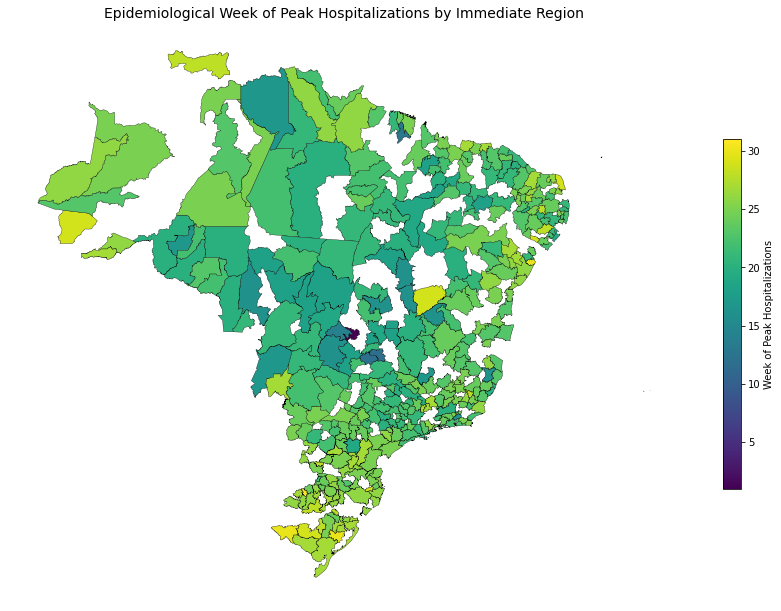

In [80]:
# Clean data
#gdf1 = gdf.dropna(subset=['year_week'])  # remove rows without peak info

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf1.plot(column='week', ax=ax, cmap='viridis', legend=True,
         legend_kwds={'label': "Week of Peak Hospitalizations", 'shrink': 0.5},
         edgecolor='black', linewidth=0.3,
         )


ax.set_title("Epidemiological Week of Peak Hospitalizations by Immediate Region", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()


In [81]:
#gdf1.sort_values(by=['week'])

gdf1.week.max()

31.0

In [87]:
# Plot hospitalizations by 100.000 inhabitants to see starting of cases
dta_aih2 = df_aih[['co_imed', 'year_week','n','warning_final_aih']]

In [97]:
dta_aih2 = dta_aih2.merge(df_codes_imed , on = 'co_imed', how = 'left')

In [99]:
dta_aih2 = dta_aih2.assign(n_inc = dta_aih2.n*100000/dta_aih2['2022'])

In [101]:
dta_aih2 = dta_aih2.assign(year = dta_aih2.year_week.astype(str).str[0:4].astype(int),
                                            week = dta_aih2.year_week.astype(str).str[5:].astype(int)
                                            )

In [114]:
dta_aih3 = dta_aih2[dta_aih2.year == 2023][['co_imed',  'warning_final_aih', 'n_inc', 'year', 'week']]

In [115]:
dta_aih3 = dta_aih3.assign(co_imed = dta_aih3.co_imed.astype(str))

In [148]:
lst = []
for code in dta_aih3.co_imed.unique():
    set_imed = dta_aih3[dta_aih3.co_imed == code]
    
    set_imed = set_imed.assign(n_inc_cum = set_imed.n_inc.cumsum())
    
    lst.append(set_imed)

In [149]:
dta_aih3 = pd.concat(lst)

In [179]:

def plot_incidence_warning_map(gdf_geom, df_data, week, cmap='Blues'):
    """
    Plots a choropleth map of cumulative incidence with warning markers for a given week.
    
    Parameters:
    - gdf_geom: GeoDataFrame with geometry and 'co_imed'
    - df_data: DataFrame with 'co_imed', 'week', 'n_inc_cum', 'warning_final_aih'
    - week: int, epidemiological week to plot
    - cmap: str, colormap name for incidence
    """
    # Merge geometry with incidence/warning data
    gdf_week = gdf_geom.merge(df_data[df_data.week == week], on='co_imed', how='left')
    
    # Plot base map
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf_week.plot(
        column='n_inc_cum',
        cmap=cmap,
        ax=ax,
        legend=True,
        legend_kwds={'label': f"Cumulative Incidence – Week {week}", 'shrink': 0.5},
        edgecolor='black',
        linewidth=0.3,
        missing_kwds={'color': 'lightgray'}
    )

    # Overlay warning markers if they exist
    gdf_warnings = gdf_week[gdf_week['warning_final_aih'] == 1]
    if not gdf_warnings.empty:
        gdf_warnings.geometry.centroid.plot(
            ax=ax,
            color='red',
            marker='*',
            markersize=50,
            label='Warning'
        )
        ax.legend(loc='lower left')

    # Final touches
    ax.set_title(f"Cumulative Incidence and Warnings – Week {week}", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


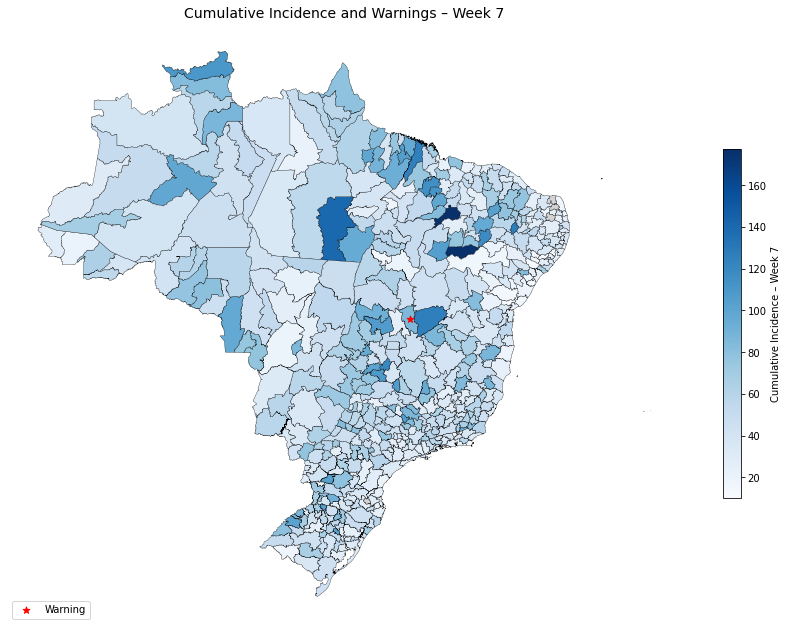

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


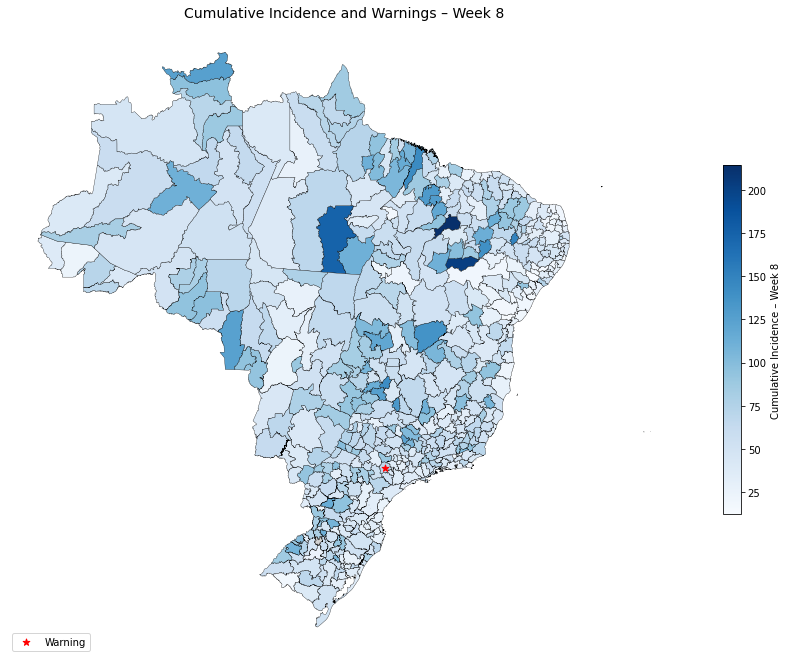

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


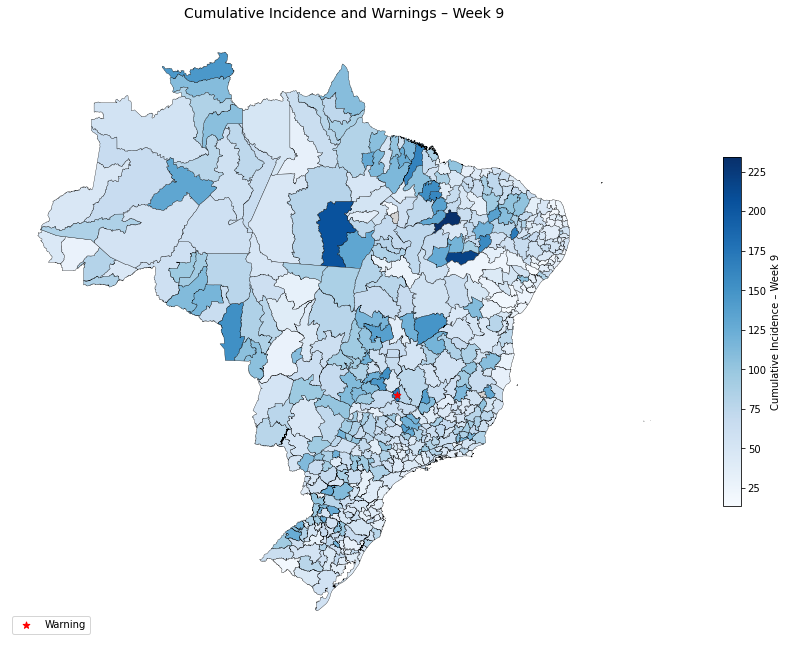

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


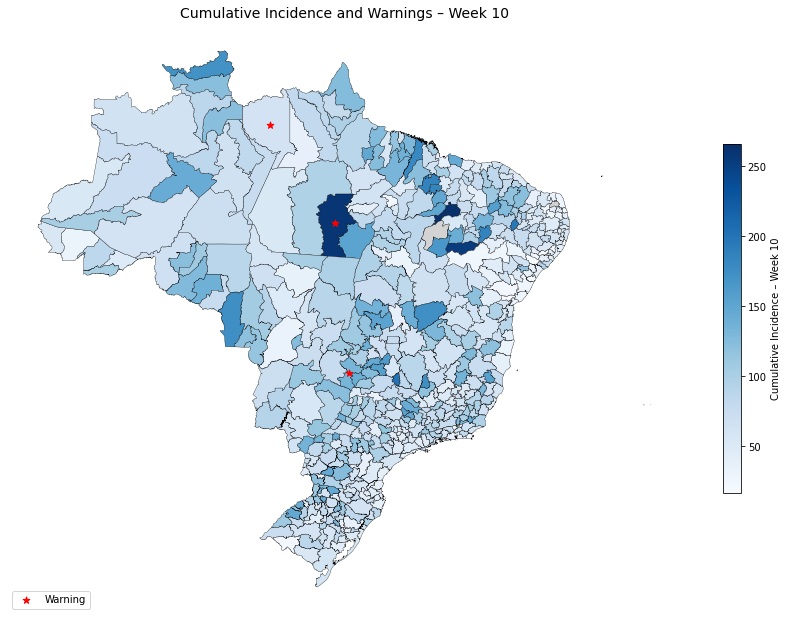

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


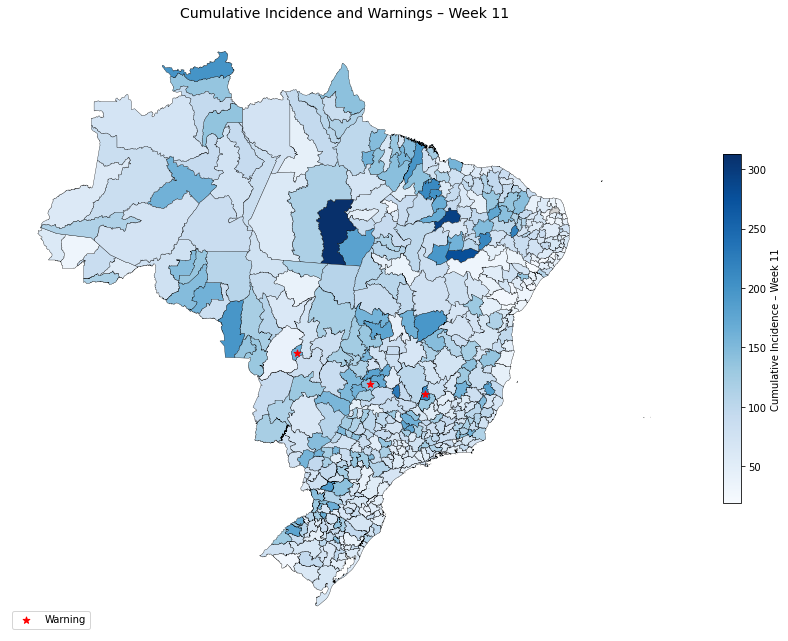

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


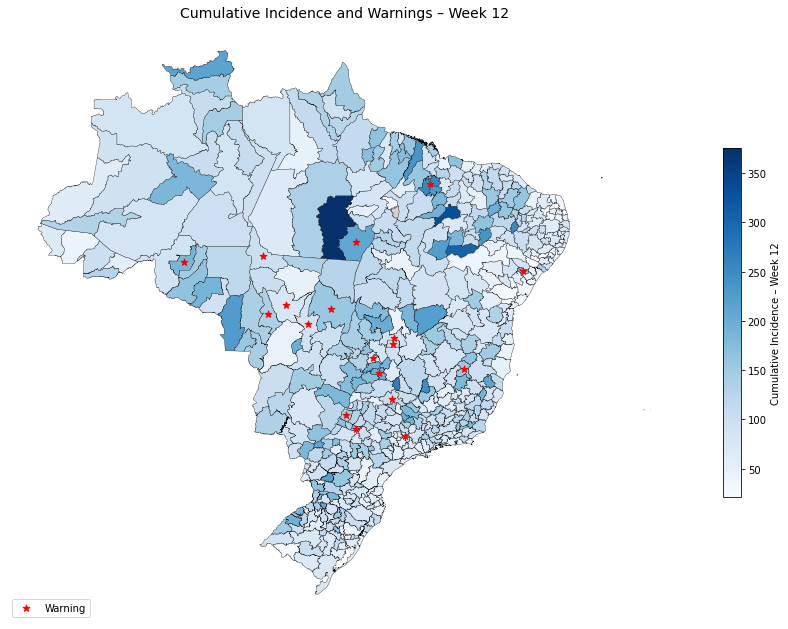

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


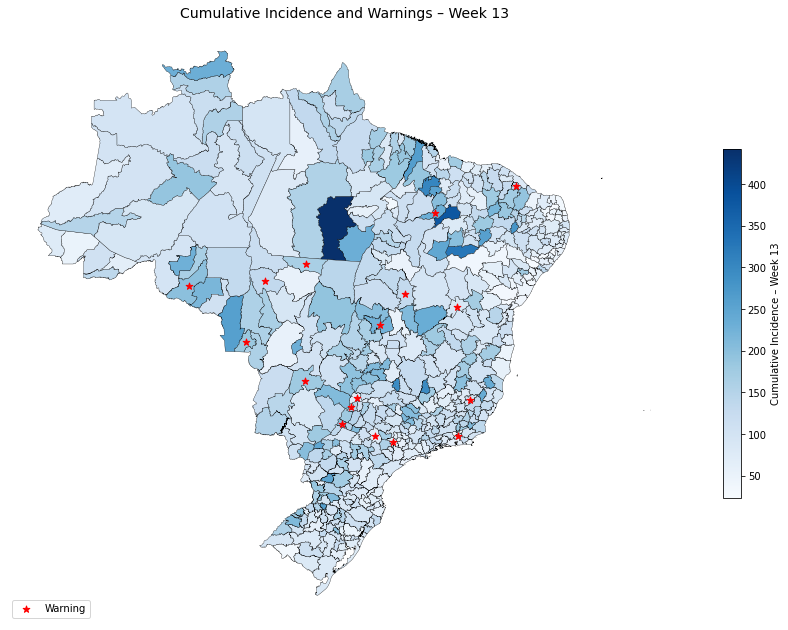

<ipython-input-179-f4ee1044f165>:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_warnings.geometry.centroid.plot(


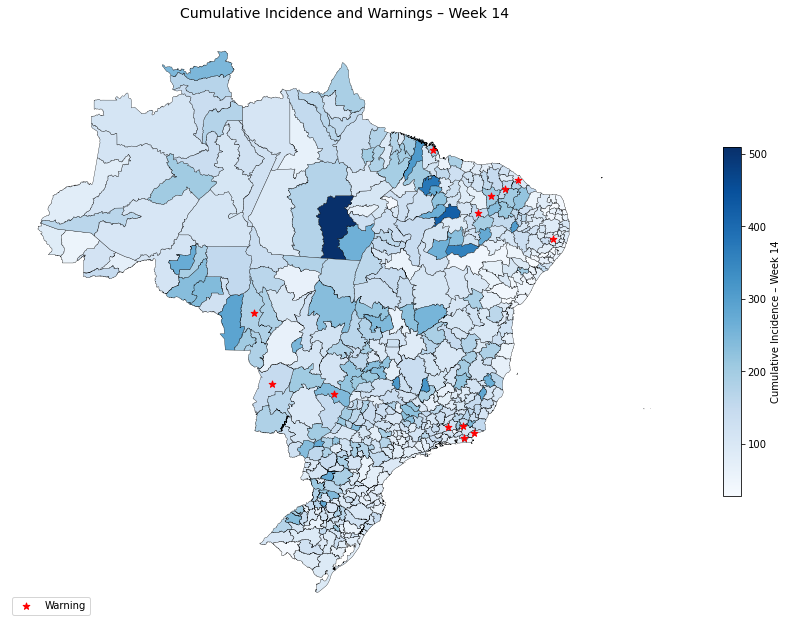

In [185]:
for wk in range(7, 15):
    plot_incidence_warning_map(gdf, dta_aih3, week=wk)
